In [18]:
#non volume preserving normalising flow
#we use gaussian mixture model for this however.

from sklearn.covariance import log_likelihood
from torch import distributions
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
os.chdir('../Data_handling')
from gmm_torch import GaussianMixture
os.chdir('../Practice')
# I will need to do batch normalisation


In [19]:

class FlowGMM(nn.Module):
    def __init__(self,layers,n_features,mixture_components,hidden_dims,d,mask):
        super().__init__()
        self.layers=layers
        self.b=mask
        self.D=n_features
        self.d=d
        self.prior=GaussianMixture(n_components=mixture_components,n_features=self.D)

        self.s_net=nn.ModuleList([nn.Sequential(
            nn.Linear(self.d,hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0],hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1],(self.D-self.d)) #d is the dimension of 1:d vector, 
                            ) for i in range(layers)])
        self.t_net=nn.ModuleList([nn.Sequential(
            nn.Linear(self.d,hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0],hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1],(self.D-self.d)) #d is the dimension of 1:d vector, 
                            ) for i in range(layers)])
    
    
    def forward(self,x):
        

        s_loss=torch.empty_like(x[:,self.d:].sum(-1))
        for i in range(self.layers):

            n=nn.BatchNorm1d(self.n_features)
            x=n(x)
            if(i%2==0):
                x1,x2=x[:,:self.d],x[:,self.d:]
            else:
                x1,x2=x[:,-self.d:],x[:,:-self.d] #is the flip
            
            st=self.st_net[i](x1)
            s,t=st[:,(self.n_features-self.d):],st[:,:(self.n_features-self.d)]

            y1=x1
            y2=x2*torch.exp(s)+t
            
            s_loss=torch.cat([s_loss,s.sum(-1)],dim=-1)

            x=torch.cat([y1,y2],-1)
        y=x

        s_loss=s_loss.sum(dim=-1)

        gmm=self.prior
        gmm.fit(y)
        
        log_likelihood=gmm.score_samples(y)
        
        loss=-1*(s_loss+log_likelihood).mean()
        
        return y, gmm, loss





In [20]:
n_samples = 10000
batch_size=1000
from torch.utils.data import DataLoader
# Define distribution. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X= noisy_moons[0]
X = StandardScaler().fit_transform(X)
X=DataLoader(torch.tensor(X).float(),batch_size=batch_size) 
model = FlowGMM(layers=5,n_features=noisy_moons[0].shape[-1],mixture_components=2,hidden_dims=[10,10],d=1)

# Training hyperparameters.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [21]:
# Increase or decrease this if you wish.
epochs=100
# Initialise the minimum loss at infinity.
min_loss = float('inf')
plot_loss=[]
# Iterate over the number of iterations.
model.train()

for epoch in range(epochs):    
        overall_loss = 0
        for batch_idx, x in enumerate(X):

            x = x.view(batch_size, len(x[0]))
            #x = x.to(DEVICE)

            optimizer.zero_grad()

            y,gmm,loss = model(x)
            
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

                
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
        print("Overall Loss: ", overall_loss)
    
print("Finish!!")





tensor([[ True, False],
        [ True,  True],
        [ True,  True],
        ...,
        [False,  True],
        [ True,  True],
        [ True, False]])
tensor([[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True, False],
        [ True,  True],
        [ True,  True]])
tensor([[ True,  True],
        [ True,  True],
        [ True, False],
        ...,
        [ True, False],
        [ True,  True],
        [False,  True]])
tensor([[False,  True],
        [ True,  True],
        [False,  True],
        ...,
        [ True, False],
        [ True,  True],
        [ True, False]])
tensor([[ True, False],
        [False,  True],
        [ True,  True],
        ...,
        [False,  True],
        [ True, False],
        [ True, False]])
tensor([[False,  True],
        [ True,  True],
        [ True, False],
        ...,
        [ True, False],
        [ True,  True],
        [ True,  True]])
tensor([[ True,  True],
        [ True,  True],
    

KeyboardInterrupt: 

In [ ]:
for i in range(len(plot_loss)):
    plot_loss[i]=plot_loss[i].detach().numpy()

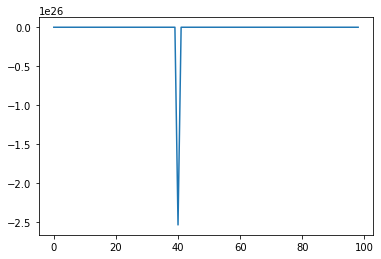

In [ ]:
import matplotlib.pyplot as plt
plt.plot(plot_loss)


In [ ]:
X[1]

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,

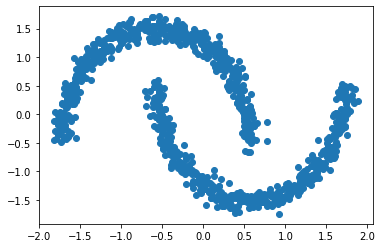

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X.transpose()[0],X.transpose()[1])